In [1]:
import os
import numpy as np
from astropy.io import fits

def process_fits_files(folder):
    """
    Processes FITS files in a directory to correct for redshift.
    
    Args:
        folder (str): Path to the directory containing FITS files.
    
    Returns:
        list: A list of tuples (loglam_rest, flux) for each file.
    """
    processed_data = []
    
    # Iterate over the files in the provided directory
    for file_name in os.listdir(folder):
        file_path = os.path.join(folder, file_name)
        
        # Skip files that do not have a .fits extension
        if not file_path.endswith('.fits'):
            continue
        
        # Open the FITS file and extract data
        with fits.open(file_path) as hdul:
            data = hdul[1].data  # Assuming data is in the second extension
            
            # Extract the relevant columns: loglam, flux, and redshift
            loglam = data['loglam']
            flux = data['flux']
            redshift = data['redshift']
            
            # Apply redshift correction to bring data to rest-frame
            loglam_rest = loglam - np.log10(1 + redshift)
            
            # Store the processed data
            processed_data.append((loglam_rest, flux))
    
    return processed_data

# Directories containing the FITS files (relative to the 'src' folder)
agn_dir = '../data/fits/agn_fits'
starburst_dir = '../data/fits/starburst_fits'


# Process the FITS files from each directory
agn_data = process_fits_files(agn_dir)
starburst_data = process_fits_files(starburst_dir)


/tmp/ipykernel_9706/1782417653.py:35: RuntimeWarning: invalid value encountered in cast
  loglam_rest = loglam - np.log10(1 + redshift)
/tmp/ipykernel_9706/1782417653.py:35: RuntimeWarning: invalid value encountered in log10
  loglam_rest = loglam - np.log10(1 + redshift)


In [5]:
# Select the first 'n' spectra from each dataset
num_samples = 2500

# Ensure that we do not exceed the total number of available spectra
agn_sample = agn_data[:num_samples] if len(agn_data) >= num_samples else agn_data
starburst_sample = starburst_data[:num_samples] if len(starburst_data) >= num_samples else starburst_data

# Log the number of selected spectra for both AGN and Starburst datasets
print(f"Number of spectra selected: {len(agn_sample)} AGN, {len(starburst_sample)} Starburst")

# Optional: Verify the dimensions of a spectrum in each sample to ensure consistency
print(f"Example AGN: loglam_rest.shape = {agn_sample[0][0].shape}, flux.shape = {agn_sample[0][1].shape}")
print(f"Example Starburst: loglam_rest.shape = {starburst_sample[0][0].shape}, flux.shape = {starburst_sample[0][1].shape}")


Number of spectra selected: 2500 AGN, 2500 Starburst
Example AGN: loglam_rest.shape = (4616,), flux.shape = (4616,)
Example Starburst: loglam_rest.shape = (4621,), flux.shape = (4621,)


In [6]:
# Interpolate spectra to match a fixed length for each spectrum
def interpolate_spectra(data, target_length):
    """
    Interpolates spectra to adjust them to a fixed length.
    
    Args:
        data (list): List of tuples (loglam_rest, flux).
        target_length (int): The number of points to which each spectrum should be interpolated.
    
    Returns:
        np.ndarray: Array of interpolated spectra (flux).
    """
    interpolated_flux = []
    
    # Loop through each spectrum and apply linear interpolation
    for loglam_rest, flux in data:
        # Generate a uniform linear space for interpolation
        x_new = np.linspace(loglam_rest.min(), loglam_rest.max(), target_length)
        flux_interp = np.interp(x_new, loglam_rest, flux)  # Linear interpolation
        interpolated_flux.append(flux_interp)
    
    return np.array(interpolated_flux)

# Interpolate the spectra to a target length
target_length = 2000  # Desired length for each spectrum
agn_flux = interpolate_spectra(agn_sample, target_length=target_length)
starburst_flux = interpolate_spectra(starburst_sample, target_length=target_length)

# Output the dimensions of the interpolated spectra to ensure correct shape
print(f"Dimensions of interpolated spectra: AGN = {agn_flux.shape}, Starburst = {starburst_flux.shape}")


/home/david/projects/tf217/env/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1599: RuntimeWarning: invalid value encountered in cast
  return interp_func(x, xp, fp, left, right)


Dimensions of interpolated spectra: AGN = (2500, 2000), Starburst = (2500, 2000)


In [7]:
# Identify valid spectra (those without NaN values)
agn_valid = ~np.isnan(agn_flux).any(axis=1)  # Check for NaN values across each spectrum (rows)
starburst_valid = ~np.isnan(starburst_flux).any(axis=1)  # Check for NaN values across each spectrum (rows)

# Filter out invalid spectra (those containing NaN values)
agn_flux = agn_flux[agn_valid]
starburst_flux = starburst_flux[starburst_valid]

# Output the number of valid spectra to verify the filtering process
print(f"Valid spectra: AGN = {agn_flux.shape}, Starburst = {starburst_flux.shape}")


Valid spectra: AGN = (2393, 2000), Starburst = (2500, 2000)


In [8]:
# Subsample the Starburst data to match the number of AGN spectra
starburst_flux = starburst_flux[:2393]  # Ensure the number of Starburst spectra matches AGN

# Output the new size of the datasets after subsampling
print(f"New dataset size: AGN = {agn_flux.shape}, Starburst = {starburst_flux.shape}")


New dataset size: AGN = (2393, 2000), Starburst = (2393, 2000)


In [9]:
import numpy as np

# Create labels: 0 for AGN, 1 for Starburst
agn_labels = np.zeros(agn_flux.shape[0])  # Labels for AGN (0)
starburst_labels = np.ones(starburst_flux.shape[0])  # Labels for Starburst (1)

# Concatenate the AGN and Starburst data
X = np.concatenate([agn_flux, starburst_flux], axis=0)  # Combine the spectra into one dataset

# Concatenate the corresponding labels
y = np.concatenate([agn_labels, starburst_labels], axis=0)  # Combine the labels into one array


In [10]:
import tensorflow as tf
import os

# Configure TensorFlow to suppress unnecessary log messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # '0' shows all logs, '1' shows warnings, '2' only errors, '3' disables logging entirely

# Disable additional CUDA-related warnings
tf.get_logger().setLevel('ERROR')  # Set TensorFlow logger to show only error messages


2025-04-10 08:56:33.120175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744296993.194275    3256 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744296993.216361    3256 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-10 08:56:33.407688: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Create the Sequential model
model = Sequential()

# Add a series of Conv1D layers with MaxPooling for feature extraction
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001), input_shape=(2000, 1)))  # First Conv1D layer
model.add(MaxPooling1D(pool_size=2))  # MaxPooling after the first Conv1D layer

model.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))  # Second Conv1D layer
model.add(MaxPooling1D(pool_size=2))  # MaxPooling after the second Conv1D layer

model.add(Conv1D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))  # Third Conv1D layer
model.add(MaxPooling1D(pool_size=2))  # MaxPooling after the third Conv1D layer

model.add(Conv1D(filters=512, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))  # Fourth Conv1D layer
model.add(MaxPooling1D(pool_size=2))  # MaxPooling after the fourth Conv1D layer

# Flatten the output to connect to fully connected layers
model.add(Flatten())

# Add fully connected Dense layers for classification
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))  # First Dense layer
model.add(Dropout(0.5))  # Dropout to prevent overfitting

model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))  # Second Dense layer
model.add(Dropout(0.5))  # Dropout to prevent overfitting

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))  # Third Dense layer
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))  # Fourth Dense layer

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and binary crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary to inspect the architecture
model.summary()

# Split the dataset into training and validation sets (70% training, 30% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Configure EarlyStopping to stop training if validation loss does not improve
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Configure ReduceLROnPlateau to reduce learning rate if validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.5,          # Reduce the learning rate by a factor of 0.5
    patience=5,          # Wait for 5 epochs without improvement before reducing the learning rate
    min_lr=1e-6          # Ensure the learning rate does not drop below 1e-6
)

# Train the model with the training set and use the validation data for evaluation
history = model.fit(
    X_train, y_train, 
    epochs=80, 
    batch_size=64, 
    validation_data=(X_val, y_val),  # Pass validation data explicitly for evaluation
    callbacks=[early_stopping, reduce_lr]  # Include EarlyStopping and ReduceLROnPlateau callbacks
)


/home/david/projects/tf217/env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744297027.563344    3256 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1998, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 999, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 997, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 498, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 496, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 248, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 246, 512)       │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 123, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    32,244,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,934,017 (125.63 MB)

 Trainable params: 32,934,017 (125.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80


I0000 00:00:1744297029.564855    4023 service.cc:148] XLA service 0x7f583c002280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744297029.565114    4023 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-04-10 08:57:09.629543: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744297029.912716    4023 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/53 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5039 - loss: 2.9699

I0000 00:00:1744297034.851048    4023 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 221ms/step - accuracy: 0.7105 - loss: 2.3504 - val_accuracy: 0.9102 - val_loss: 1.3939 - learning_rate: 0.0010
Epoch 2/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8995 - loss: 1.2775 - val_accuracy: 0.9234 - val_loss: 1.0013 - learning_rate: 0.0010
Epoch 3/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9210 - loss: 0.9703 - val_accuracy: 0.9311 - val_loss: 0.8542 - learning_rate: 0.0010
Epoch 4/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9452 - loss: 0.8289 - val_accuracy: 0.9234 - val_loss: 0.8509 - learning_rate: 0.0010
Epoch 5/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9442 - loss: 0.7481 - val_accuracy: 0.9506 - val_loss: 0.6707 - learning_rate: 0.0010
Epoch 6/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9580 - loss: 0.6351 - val_accuracy: 0.9561 - val_loss: 0.7229 - learning_rate: 0.0010
Epoch 7/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9653 - loss: 0.6184 - val_accuracy: 0.

In [12]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val, y_val, batch_size=32)  # Evaluate using batch_size of 32

# Print the loss and accuracy metrics on the validation set
print(f"Validation loss: {loss}")
print(f"Validation accuracy: {accuracy}")


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9711 - loss: 0.2746
Validation loss: 0.2277681976556778
Validation accuracy: 0.9707520604133606


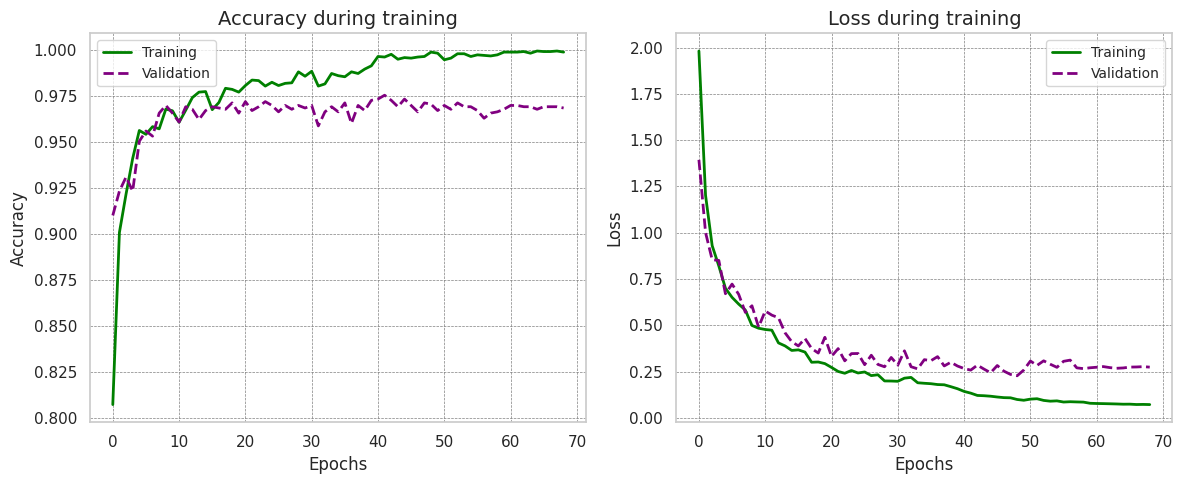

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots using seaborn
sns.set_theme(style="whitegrid")

# Define custom colors for training and validation curves
train_color = "green"  # Green color for training curve
val_color = "purple"   # Purple color for validation curve

# Create a figure with a specific size
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training', color=train_color, linewidth=2)  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation', color=val_color, linestyle='--', linewidth=2)  # Plot validation accuracy
plt.title('Accuracy during training', fontsize=14)  # Title of the accuracy plot
plt.xlabel('Epochs', fontsize=12)  # X-axis label (Epochs)
plt.ylabel('Accuracy', fontsize=12)  # Y-axis label (Accuracy)
plt.legend(fontsize=10)  # Display legend with font size 10
plt.grid(color='gray', linestyle='--', linewidth=0.5)  # Add grid for better visualization

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training', color=train_color, linewidth=2)  # Plot training loss
plt.plot(history.history['val_loss'], label='Validation', color=val_color, linestyle='--', linewidth=2)  # Plot validation loss
plt.title('Loss during training', fontsize=14)  # Title of the loss plot
plt.xlabel('Epochs', fontsize=12)  # X-axis label (Epochs)
plt.ylabel('Loss', fontsize=12)  # Y-axis label (Loss)
plt.legend(fontsize=10)  # Display legend with font size 10
plt.grid(color='gray', linestyle='--', linewidth=0.5)  # Add grid for better visualization

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


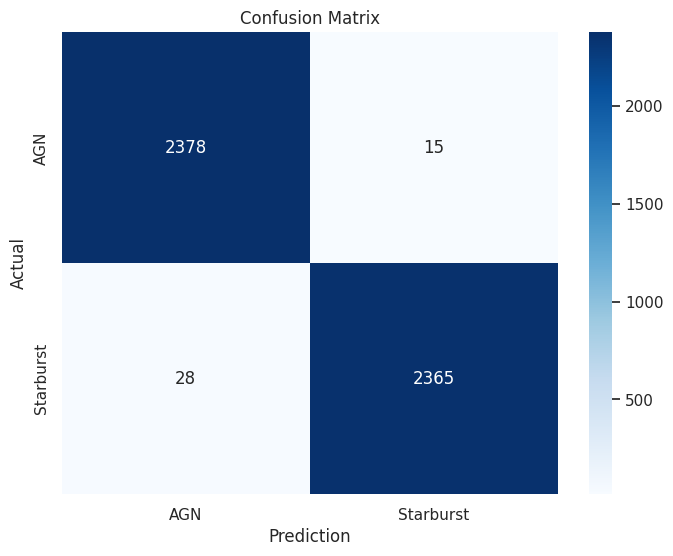

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np

# Make predictions with the trained model
y_pred = model.predict(X)  # Get the predicted probabilities for each class

# Convert the predicted probabilities to labels (0 or 1) based on a threshold of 0.5
y_pred_labels = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)

# Generate the confusion matrix to compare true labels with predicted labels
cm = confusion_matrix(y, y_pred_labels)  # Compute confusion matrix

# Visualize the confusion matrix with a heatmap for better interpretation
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['AGN', 'Starburst'], yticklabels=['AGN', 'Starburst'])  # Plot confusion matrix
plt.title('Confusion Matrix')  # Title of the confusion matrix plot
plt.xlabel('Prediction')  # X-axis label (Predicted class)
plt.ylabel('Actual')  # Y-axis label (True class)
plt.show()  # Display the plot


In [15]:
# Save the trained model to a file for later use
model.save('modelo_david_galaxies.keras')  # Save the model in Keras' .keras format
